In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

from dask_jobqueue import SLURMCluster
from distributed import Client
%matplotlib inline

In [3]:
cluster = SLURMCluster(walltime="8:00:00", memory="128GB", cores=36)
cluster.scale(18)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://140.221.70.6:8787/status,
Dashboard: http://140.221.70.6:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://140.221.70.6:33093,Workers: 0
Dashboard: http://140.221.70.6:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
microbase_ds_2004 = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/nsa_microbase/*2004*', combine='nested', concat_dim='time', parallel=True)
microbase_ds_2005 = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/nsa_microbase/*2005*', combine='nested', concat_dim='time', parallel=True)
microbase_ds_2006 = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/nsa_microbase/:wq*2006*', combine='nested', concat_dim='time', parallel=True)
microbase_ds = xr.concat([microbase_ds_2004, microbase_ds_2005, microbase_ds_2006], dim='time')

In [6]:
microbase_ds

<xarray.Dataset>
Dimensions:                    (time: 73368, heights: 233)
Coordinates:
  * time                       (time) datetime64[ns] 2004-01-01T00:10:00 ... ...
  * heights                    (heights) float32 149.5 212.5 ... 2.285e+04
Data variables: (12/16)
    base_time                  (time) datetime64[ns] 2004-01-01T00:10:00 ... ...
    time_offset                (time) datetime64[ns] dask.array<chunksize=(72,), meta=np.ndarray>
    avg_retrieved_lwc          (time, heights) float32 dask.array<chunksize=(72, 233), meta=np.ndarray>
    avg_retrieved_iwc          (time, heights) float32 dask.array<chunksize=(72, 233), meta=np.ndarray>
    avg_liq_effective_radius   (time, heights) float32 dask.array<chunksize=(72, 233), meta=np.ndarray>
    avg_ice_effective_radius   (time, heights) float32 dask.array<chunksize=(72, 233), meta=np.ndarray>
    ...                         ...
    integrated_cloud_fraction  (time) float32 dask.array<chunksize=(72,), meta=np.ndarray>
    aqc_cloud_fraction         (time) float32 dask.array<chunksize=(72,), meta=np.ndarray>
    aqc_cloud_missing          (time) float32 dask.array<chunksize=(72,), meta=np.ndarray>
    lat                        (time) float32 70.47 70.47 70.47 ... 70.47 70.47
    lon                        (time) float32 -157.4 -157.4 ... -157.4 -157.4
    alt                        (time) float32 8.0 8.0 8.0 8.0 ... 8.0 8.0 8.0
Attributes:
    process_version:                $State: vap-microbasepi-1.2-0.sol5_10 $
    command_line:                   microbasepi -d 20040101 -f nsaC1
    site_id:                        nsa
    facility_id:                    C1: Barrow, Alaska
    input_datastreams_description:  A string consisting of the datastream(s),...
    input_datastreams_num:          3
    input_datastreams:              nsaarscl1clothC1.c1 : $State: Release_2_1...
    zeb_platform:                   nsamicrobasepiavgC1.c1
    history:                        created by user mdunn on machine topaz at...
    dod_version:                    v1.0 
    qc_standards_version:           1.0

In [26]:
microbase_ds = xr.concat([microbase_ds_2004, microbase_ds_2005, microbase_ds_2006], dim='time')
microbase_ds["Avg_Retrieved_IWC"] = microbase_ds["avg_retrieved_iwc"] / 1e3
microbase_ds["Avg_Retrieved_IWC"] = microbase_ds["Avg_Retrieved_IWC"].where(
    microbase_ds["Avg_Retrieved_IWC"] > 1e-4)
microbase_ds["Avg_Retrieved_LWC"] = microbase_ds["avg_retrieved_lwc"].where(
    microbase_ds["avg_retrieved_lwc"] > 1e-4)
microbase_ds['ice_present_2d'] = (microbase_ds["Avg_Retrieved_IWC"] > 1e-4) * 1.
microbase_ds['liquid_present_2d'] = (microbase_ds["avg_retrieved_lwc"] > 1e-4) * 1.
microbase_ds["time"] = microbase_ds["time_offset"]

In [18]:
# Shupe turner only
microbase_ds = xr.concat([microbase_ds_2004, microbase_ds_2005, microbase_ds_2006], dim='time')
microbase_ds["liquid_present"] = microbase_ds["CloudPhaseMask"].isin(
    [3, 4, 5, 6, 7]).max(dim='nheights') * 1.
microbase_ds["ice_present"] = microbase_ds["CloudPhaseMask"].isin(
    [1, 2, 7]).max(dim='nheights') * 1.
microbase_ds["liquid_present_2d"] = microbase_ds["CloudPhaseMask"].isin(
    [3, 4, 5, 6, 7]) * 1.
microbase_ds["ice_present_2d"] = microbase_ds["CloudPhaseMask"].isin(
    [1, 2, 7]) * 1.
microbase_ds["mixed_present"] = microbase_ds["CloudPhaseMask"].isin(
    [7]).max(dim='nheights') * 1.
microbase_ds["cloud_present"] = microbase_ds["CloudPhaseMask"].isin(
    [1, 2, 3, 4, 5, 6, 7]).max(dim='nheights') * 1.
microbase_ds["liquid_present_only"] = microbase_ds["CloudPhaseMask"].isin(
    [3, 4, 5, 6]).max(dim='nheights') * 1.
microbase_ds["ice_present_only"] = microbase_ds["CloudPhaseMask"].isin(
    [1, 2]).max(dim='nheights') * 1.
microbase_ds["liquid_present"] = microbase_ds["liquid_present"].where(
    microbase_ds["cloud_present"] > 0)
microbase_ds["ice_present"] = microbase_ds["ice_present"].where(
    microbase_ds["cloud_present"] > 0)
microbase_ds["mixed_present"] = microbase_ds["mixed_present"].where(
    microbase_ds["cloud_present"] > 0)
microbase_ds["ice_present_only"] = microbase_ds["ice_present_only"].where(
    microbase_ds["cloud_present"] > 0)
microbase_ds["liquid_present_only"] = microbase_ds["ice_present_only"].where(
    microbase_ds["cloud_present"] > 0)
microbase_ds["Avg_Retrieved_IWC"] = microbase_ds["Avg_Retrieved_IWC"] / 1e3
microbase_ds["Avg_Retrieved_IWC"] = microbase_ds["Avg_Retrieved_IWC"].where(
    np.logical_and(microbase_ds["cloud_present"] > 0, microbase_ds["Avg_Retrieved_IWC"] > 1e-4))
microbase_ds["Avg_Retrieved_LWC"] = microbase_ds["Avg_Retrieved_LWC"].where(
    np.logical_and(microbase_ds["cloud_present"] > 0, microbase_ds["Avg_Retrieved_LWC"] > 1e-4))
microbase_ds["time"] = microbase_ds["time_offset"]


In [27]:
monthly_turner = microbase_ds.groupby("time.month").mean(skipna=True)
monthly_turner = monthly_turner.set_coords(["month", "heights"])

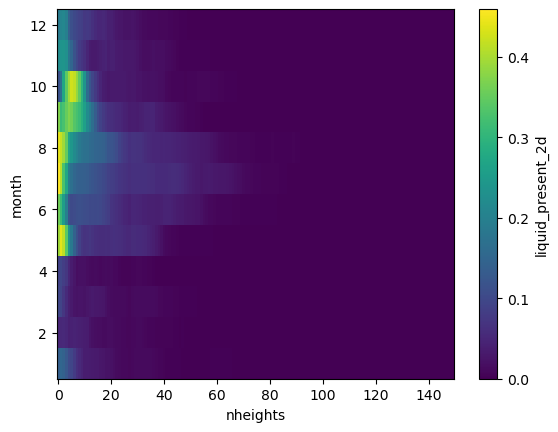

In [45]:
monthly_turner.liquid_present_2d.plot.pcolormesh()

[Text(1, 0, 'J'),
 Text(2, 0, 'F'),
 Text(3, 0, 'M'),
 Text(4, 0, 'A'),
 Text(5, 0, 'M'),
 Text(6, 0, 'J'),
 Text(7, 0, 'J'),
 Text(8, 0, 'A'),
 Text(9, 0, 'S'),
 Text(10, 0, 'O'),
 Text(11, 0, 'N'),
 Text(12, 0, 'D')]

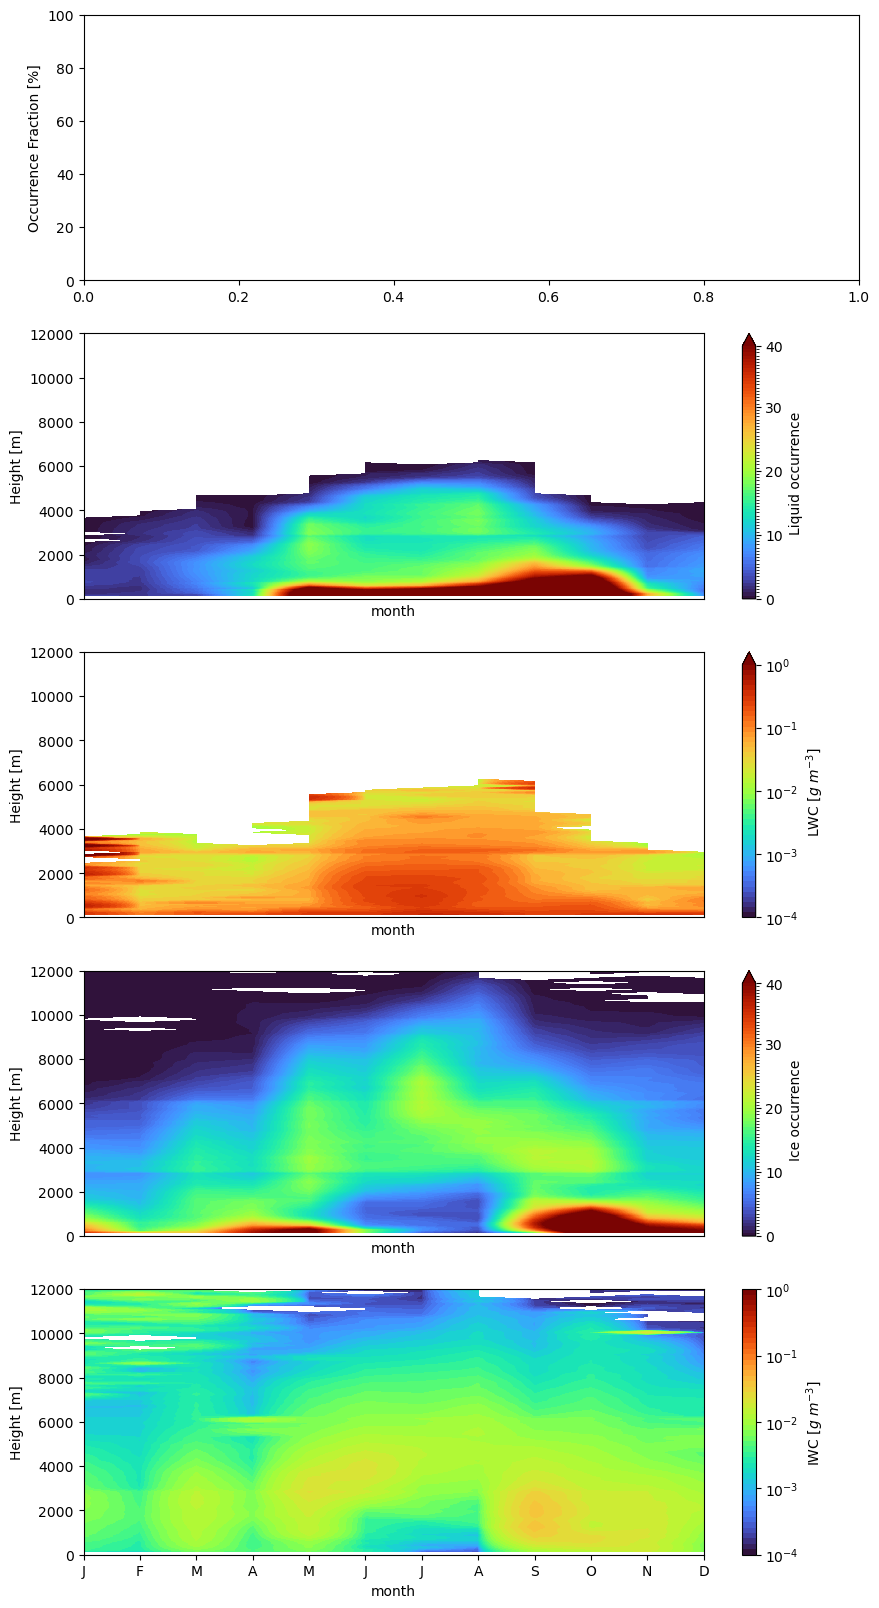

In [28]:
fig, ax = plt.subplots(5, 1, figsize=(10, 20))
#(monthly_turner["cloud_present"] * 100).plot(ax=ax[0], color='k')
#(monthly_turner["ice_present"] * 100).plot(ax=ax[0], color='b')
#(monthly_turner["ice_present_only"] * 100).plot(ax=ax[0], color='b', linestyle='--')
#(monthly_turner["liquid_present"] * 100).plot(ax=ax[0], color='tab:orange')
#(monthly_turner["liquid_present_only"] * 100).plot(ax=ax[0], color='tab:orange', linestyle='--')
#(monthly_turner["mixed_present"] * 100).plot(ax=ax[0], color='g')
ax[0].set_ylim([0, 100])
ax[0].set_ylabel('Occurrence Fraction [%]')
cbar_kwargs = {'label': "Liquid occurrence", "extend": [0, 40.],
               'ticks':[0, 10, 20, 30, 40]}
(monthly_turner["liquid_present_2d"] * 100).where(
    monthly_turner["liquid_present_2d"] > 0).T.plot.contourf(
    ax=ax[1], cmap='turbo', y='heights', cbar_kwargs=cbar_kwargs, vmin=0, vmax=40,
    levels=np.arange(0, 40, 0.5))
ax[1].set_ylim([0, 12000])
ax[1].set_ylabel("Height [m]")
cbar_kwargs = {'label': "LWC [$g\ m^{-3}$]", "extend": [1e-4, 1],
               'ticks': [1e-4, 1e-3, 1e-2, 1e-1, 1]}
monthly_turner["Avg_Retrieved_LWC"].where(
    monthly_turner["Avg_Retrieved_LWC"] > 1e-2).T.plot.contourf(
    ax=ax[2], levels=np.logspace(-4, 0, 50), cmap='turbo', y='heights',
    cbar_kwargs=cbar_kwargs, vmin=1e-4, vmax=1, norm=colors.LogNorm(1e-4, 1)
)
ax[2].set_ylim([0, 12000])
ax[2].set_ylabel("Height [m]")
cbar_kwargs = {'label': "Ice occurrence", "extend": [0, 40.],
               'ticks': [0, 10, 20, 30, 40]}
(monthly_turner["ice_present_2d"] * 100).where(
    monthly_turner["ice_present_2d"] > 0).T.plot.contourf(
    ax=ax[3], cmap='turbo', y='heights', cbar_kwargs=cbar_kwargs, vmin=0, vmax=40,
    levels=np.arange(0, 40, 0.5))
ax[3].set_ylim([0, 12000])
ax[3].set_ylabel("Height [m]")

cbar_kwargs = {'label': "IWC [$g\ m^{-3}$]", "extend": [1e-4, 1],
               'ticks': [1e-4, 1e-3, 1e-2, 1e-1, 1]}
monthly_turner["Avg_Retrieved_IWC"].T.plot.contourf(
    ax=ax[4], levels=np.logspace(-4, 0, 50), cmap='turbo', y='heights',
    cbar_kwargs=cbar_kwargs, vmin=1e-4, vmax=1, norm=colors.LogNorm(1e-4, 1)
)
ax[4].set_ylim([0, 12000])
ax[4].set_ylabel("Height [m]")
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])
ax[4].set_xticks([])
ax[4].set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax[4].set_xticklabels(['J', 'F', 'M', 'A', "M", "J", "J", "A", "S", 'O', 